# Lab 8 – Distances and PCA

### Name: Bryce DiRisio and Eli Mauskopf

### Class: CSCI 349 - Intro to Data Mining

### Semester: 2020SP

### Instructor: Brian King

The code below is needed to run the lab

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import zscore
from sklearn.decomposition import PCA
import math

### 1) [P] Set up a pandas data frame with the following 8 observations and 3 variables:

In [3]:
test1 = pd.Categorical(['A','C','C','B','A','B','C','B'])
test2 = pd.Categorical(['excellent','fair','good','fair','poor','excellent','good','good'],ordered=True,categories=['poor','fair','good','excellent'])
test3 = [25,32,60,53,23,37,45,49]
df = pd.DataFrame(columns=['test1','test2','test3'],index=['A0','A1','A2','A3','A4','A5','A6','A7'])
df['test1'] = test1
df['test2'] = test2
df['test3'] = test3

df

test1      test2  test3
A0     A  excellent     25
A1     C       fair     32
A2     C       good     60
A3     B       fair     53
A4     A       poor     23
A5     B  excellent     37
A6     C       good     45
A7     B       good     49

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, A0 to A7
Data columns (total 3 columns):
test1    8 non-null category
test2    8 non-null category
test3    8 non-null int64
dtypes: category(2), int64(1)
memory usage: 440.0+ bytes


### 2) [P] Show the output of df.describe(include='all'). What does the include='all' parameter do?

In [5]:
df.describe(include='all')

#The 'include='all'' means that it will analyze the statistics for each column

test1 test2      test3
count      8     8   8.000000
unique     3     4        NaN
top        C  good        NaN
freq       3     3        NaN
mean     NaN   NaN  40.500000
std      NaN   NaN  13.416408
min      NaN   NaN  23.000000
25%      NaN   NaN  30.250000
50%      NaN   NaN  41.000000
75%      NaN   NaN  50.000000
max      NaN   NaN  60.000000

### 3) [P] Show the output of df.test1.cat.categories, and df.test2.cat.categories. What is this showing? Does it work for df.test3.cat.categories? (If not, then comment this line out.)

In [6]:
display(df.test1.cat.categories)
display(df.test2.cat.categories)

#The above line is showing the number of categories contained in the column

#display(df.test3.cat.categories) <--- This line does not work

Index(['A', 'B', 'C'], dtype='object')

Index(['poor', 'fair', 'good', 'excellent'], dtype='object')

### 4) [P] Show the output of df.test1.cat.codes, and df.test2.cat.codes. What is this showing?

In [7]:
display(df.test1.cat.codes)
display(df.test2.cat.codes)

#This is showing a conversion of the categories in the column to numeric (int8) values

A0    0
A1    2
A2    2
A3    1
A4    0
A5    1
A6    2
A7    1
dtype: int8

A0    3
A1    1
A2    2
A3    1
A4    0
A5    3
A6    2
A7    2
dtype: int8

### 5) [P] Report the counts of each level of the categorical variables.

In [8]:
display(df.test1.value_counts())
display(df.test2.value_counts())

C    3
B    3
A    2
Name: test1, dtype: int64

good         3
excellent    2
fair         2
poor         1
Name: test2, dtype: int64

### 6) [P] Report a cross tabulation (i.e. contingency table) between test1 and test2. Include the margins (i.e. the sum of the rows and the columns) in your reported table (HINT: Look up pandas crosstab() function)

In [9]:
pd.crosstab(test1,test2,margins=True)

col_0  poor  fair  good  excellent  All
row_0                                  
A         1     0     0          1    2
B         0     1     1          1    3
C         0     1     2          0    3
All       1     2     3          2    8

### 7) [P] From the previous table, store the contingency table without the margins in a variable called observed

In [10]:
observed = pd.crosstab(test1,test2)
observed

col_0  poor  fair  good  excellent
row_0                             
A         1     0     0          1
B         0     1     1          1
C         0     1     2          0

### 8) [P] Run a chi-squared test to determine whether test1 and test2 are dependent. Use the contingency table from the previous step. Clearly report the chi2 statistic, the p value, and the degrees of freedom, and then use the p-value to clearly state whether test1 and test2 are independent (assume p=0.05 threshold to test for independence) Now, you're going to explore some similarities between observations. Yes, this is a SMALL dataset! (Don't bother to explore large data until you can understand how they work on small, toy experimental data!) Before you can compute a pairwise distance matrix to report the distance between all pairs of observations, always remember that you can only compute distances between strictly numeric data. Therefore, you must convert your data to numeric types for ALL variables you want to include in your distance metric.

In [11]:
chiResult = stats.chisquare(f_obs=observed)

print("Chi Result = {}".format(chiResult.statistic))
print("Chi Result = {}".format(chiResult.pvalue))

#Looking at the p value, we see that the categories are definitely independent of each other.

Chi Result = [2. 1. 2. 1.]
Chi Result = [0.36787944 0.60653066 0.36787944 0.60653066]


### 9) [P] Create a new data frame called df_num, that represents a numeric version of the above. Do NOT do any rescaling of your variables yet!

In [12]:
df_num = pd.DataFrame(columns=['test1','test2','test3'],index=['A0','A1','A2','A3','A4','A5','A6','A7'])
df_num['test1'] = df.test1.cat.codes
df_num['test2'] = df.test2.cat.codes
df_num['test3'] = df['test3']

df_num

test1  test2  test3
A0      0      3     25
A1      2      1     32
A2      2      2     60
A3      1      1     53
A4      0      0     23
A5      1      3     37
A6      2      2     45
A7      1      2     49

### 10) [P] As you learned in lecture, you absolutely must rescale your data to fall on a similar scale. There are different approaches to doing so. A standardized zscore is among the most common, but not necessarily always the best approach, especially when you are dealing with numeric representations of true categorical data. Rescaling your data to all fall between 0 and 1 is also a common approach, particularly when you have categorical data. Let's first try to rescale our data to all fall between the values of 0 and 1. Use the MinMaxScaler in sklearn.preprocessing to rescale all variables to fall between 0 and 1. Store the transformed data as a pandas data frame called df_num_zeroone.

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_num_fit = scaler.fit(df_num.iloc[0:,0:])
df_num_zeroone = pd.DataFrame(data=df_num_fit.transform(X=df_num),columns=['test1','test2','test3'],index=['A0','A1','A2','A3','A4','A5','A6','A7'])
df_num_zeroone

test1     test2     test3
A0    0.0  1.000000  0.054054
A1    1.0  0.333333  0.243243
A2    1.0  0.666667  1.000000
A3    0.5  0.333333  0.810811
A4    0.0  0.000000  0.000000
A5    0.5  1.000000  0.378378
A6    1.0  0.666667  0.594595
A7    0.5  0.666667  0.702703

### 11) [P] Notice the value of test3. Quite often, when we have solid knowledge of what we expect our range to be, then we can rescale our data using that knowledge. In the case of test3, you learned that the data must fall between 0 and 100. Therefore, reassign test3 so that the min and max before rescaling are assuming to be between 0 and 100, respectively. (i.e. simply divide the original variable by 100)

In [14]:
df_num_zeroone['test3'] = [test3[i]/100 for i in range(df_num_zeroone.shape[0])]
df_num_zeroone

test1     test2  test3
A0    0.0  1.000000   0.25
A1    1.0  0.333333   0.32
A2    1.0  0.666667   0.60
A3    0.5  0.333333   0.53
A4    0.0  0.000000   0.23
A5    0.5  1.000000   0.37
A6    1.0  0.666667   0.45
A7    0.5  0.666667   0.49

### 12) [P] Compute a single distance matrix called distmat_zeroone. Use a standard Euclidean distance measure. Your reported result should be an 8x8 matrix with appropriately labeled rows and columns. (HINT – study the output of the distance matrix functions! They do not output a square matrix. Look at the squareform function. The pdist and squareform functions are in scipy.spatial.distance).

In [15]:
from scipy.spatial import distance

distmat_zeroone = distance.pdist(df_num.iloc[0:,0:])
distmat_zeroone = distance.squareform(distmat_zeroone)
display(distmat_zeroone)

array([[ 0.        ,  7.54983444, 35.07135583, 28.08914381,  3.60555128,
        12.04159458, 20.1246118 , 24.04163056],
       [ 7.54983444,  0.        , 28.01785145, 21.02379604,  9.2736185 ,
         5.47722558, 13.03840481, 17.05872211],
       [35.07135583, 28.01785145,  0.        ,  7.14142843, 37.10795063,
        23.04343724, 15.        , 11.04536102],
       [28.08914381, 21.02379604,  7.14142843,  0.        , 30.03331484,
        16.1245155 ,  8.1240384 ,  4.12310563],
       [ 3.60555128,  9.2736185 , 37.10795063, 30.03331484,  0.        ,
        14.35270009, 22.18107301, 26.0959767 ],
       [12.04159458,  5.47722558, 23.04343724, 16.1245155 , 14.35270009,
         0.        ,  8.1240384 , 12.04159458],
       [20.1246118 , 13.03840481, 15.        ,  8.1240384 , 22.18107301,
         8.1240384 ,  0.        ,  4.12310563],
       [24.04163056, 17.05872211, 11.04536102,  4.12310563, 26.0959767 ,
        12.04159458,  4.12310563,  0.        ]])

### 13) [P] Output the top three closest pairs of observations. You MUST write Python code to report these results! Do not simply print out your distance matrix and tell me your answers! Consider that this may have been thousands of observations! Always generate reported answers in code! For each pair, output the pair of observations from the original dataframe, and the distance between them. For example, your first closest pair output might have output that looks as follows:

In [16]:
#gets the three minimum values
testPD = pd.DataFrame(data=distmat_zeroone)
threeMinVals = testPD.stack().sort_values().iloc[len(distmat_zeroone):].head(6)

for i in range(0,6,2):
    valArr = []
    val1 = df.iloc[threeMinVals.index[i][0]]
    val2 = df.iloc[threeMinVals.index[i][1]]
    valArr.append(val1.name)
    valArr.append(val2.name)
    print('\n')
    print("Closest " + str(i//2) + ": " + str(valArr) + " dist = " + str(threeMinVals.values[i]))
    print('------------')
    display(df.loc[val1.name])
    display(df.loc[val2.name])



Closest 0: ['A4', 'A0'] dist = 3.605551275463989
------------


test1       A
test2    poor
test3      23
Name: A4, dtype: object

test1            A
test2    excellent
test3           25
Name: A0, dtype: object



Closest 1: ['A3', 'A7'] dist = 4.123105625617661
------------


test1       B
test2    fair
test3      53
Name: A3, dtype: object

test1       B
test2    good
test3      49
Name: A7, dtype: object



Closest 2: ['A6', 'A7'] dist = 4.123105625617661
------------


test1       C
test2    good
test3      45
Name: A6, dtype: object

test1       B
test2    good
test3      49
Name: A7, dtype: object

### 14) [P] Now, output the three most distant (least similar) pairs of observations. Again, for each pair, output the two observations, and the distance between them

In [17]:
#gets the three maximum values
testPD = pd.DataFrame(data=distmat_zeroone)
threeMaxVals = testPD.stack().sort_values().iloc[len(distmat_zeroone):].tail(6)

for i in range(0,6,2):
    valArr = []
    val1 = df.iloc[threeMaxVals.index[i][0]]
    val2 = df.iloc[threeMaxVals.index[i][1]]
    valArr.append(val1.name)
    valArr.append(val2.name)
    print('\n')
    print("Furthest " + str(i//2) + ": " + str(valArr) + " dist = " + str(threeMaxVals.values[i]))
    print('------------')
    display(df.loc[val1.name])
    display(df.loc[val2.name])



Furthest 0: ['A4', 'A3'] dist = 30.033314835362415
------------


test1       A
test2    poor
test3      23
Name: A4, dtype: object

test1       B
test2    fair
test3      53
Name: A3, dtype: object



Furthest 1: ['A2', 'A0'] dist = 35.07135583350036
------------


test1       C
test2    good
test3      60
Name: A2, dtype: object

test1            A
test2    excellent
test3           25
Name: A0, dtype: object



Furthest 2: ['A4', 'A2'] dist = 37.107950630558946
------------


test1       A
test2    poor
test3      23
Name: A4, dtype: object

test1       C
test2    good
test3      60
Name: A2, dtype: object

### 15) [P] Create a new data frame, df_num_binarized, that stores the a binarized version for test1 and test2.

In [18]:
def binarize(dataSeries,categoryLabel):
    binarySeries = pd.Series()
    for i in range(0,dataSeries.shape[0]):
        if str(dataSeries[i]) == categoryLabel:
            binarySeries = binarySeries.append(pd.Series(1))
        else:
            binarySeries = binarySeries.append(pd.Series(0))
    return binarySeries

df_num_binarized = pd.DataFrame(data=binarize(df.iloc[:,0],'A'),columns=['test1_A'])

df_num_binarized['test1_B'] = pd.DataFrame(data=binarize(df.iloc[:,0],'B'))
df_num_binarized['test1_C'] = pd.DataFrame(data=binarize(df.iloc[:,0],'C'))
df_num_binarized['test2_poor'] = pd.DataFrame(data=binarize(df.iloc[:,1],'poor'))
df_num_binarized['test2_fair'] = pd.DataFrame(data=binarize(df.iloc[:,1],'fair'))
df_num_binarized['test2_good'] = pd.DataFrame(data=binarize(df.iloc[:,1],'good'))
df_num_binarized['test2_excellent'] = pd.DataFrame(data=binarize(df.iloc[:,1],'excellent'))
df_num_binarized.index = ['A0','A1','A2','A3','A4','A5','A6','A7']
df_num_binarized['test3'] = df_num_zeroone['test3']

df_num_binarized

test1_A  test1_B  test1_C  test2_poor  test2_fair  test2_good  \
A0        1        0        0           0           0           0   
A1        0        0        1           0           1           0   
A2        0        0        1           0           0           1   
A3        0        1        0           0           1           0   
A4        1        0        0           1           0           0   
A5        0        1        0           0           0           0   
A6        0        0        1           0           0           1   
A7        0        1        0           0           0           1   

    test2_excellent  test3  
A0                1   0.25  
A1                0   0.32  
A2                0   0.60  
A3                0   0.53  
A4                0   0.23  
A5                1   0.37  
A6                0   0.45  
A7                0   0.49

### 16) [P] Now, compute distmat_binarized by computing the distance matrix for the df_binarized.

In [19]:
distmat_binarized = distance.pdist(df_num_binarized.iloc[0:,0:])
distmat_binarized = distance.squareform(distmat_binarized)
display(distmat_binarized)

array([[0.        , 2.00122463, 2.03039405, 2.01950489, 1.41435498,
        1.4192956 , 2.00997512, 2.01434853],
       [2.00122463, 0.        , 1.4416657 , 1.42972025, 2.00202398,
        2.0006249 , 1.42017605, 2.007212  ],
       [2.03039405, 1.4416657 , 0.        , 2.00122463, 2.03393707,
        2.01318156, 0.15      , 1.41848511],
       [2.01950489, 1.42972025, 2.00122463, 0.        , 2.02237484,
        1.42323575, 2.00159936, 1.41477913],
       [1.41435498, 2.00202398, 2.03393707, 2.02237484, 0.        ,
        2.00489401, 2.01206362, 2.01682919],
       [1.4192956 , 2.0006249 , 2.01318156, 1.42323575, 2.00489401,
        0.        , 2.00159936, 1.4192956 ],
       [2.00997512, 1.42017605, 0.15      , 2.00159936, 2.01206362,
        2.00159936, 0.        , 1.41477913],
       [2.01434853, 2.007212  , 1.41848511, 1.41477913, 2.01682919,
        1.4192956 , 1.41477913, 0.        ]])

### 17) [P] Report the three closest pairs, and the three most distant pairs from distmat_binarized

In [20]:
#gets the three minimum values
testPD = pd.DataFrame(data=distmat_binarized)
threeMinVals = testPD.stack().sort_values().iloc[len(distmat_binarized):].head(6)

for i in range(0,6,2):
    valArr = []
    val1 = df.iloc[threeMinVals.index[i][0]]
    val2 = df.iloc[threeMinVals.index[i][1]]
    valArr.append(val1.name)
    valArr.append(val2.name)
    print('\n')
    print("Closest " + str(i//2) + ": " + str(valArr) + " dist = " + str(threeMinVals.values[i]))
    print('------------')
    display(df.loc[val1.name])
    display(df.loc[val2.name])



Closest 0: ['A6', 'A2'] dist = 0.14999999999999997
------------


test1       C
test2    good
test3      45
Name: A6, dtype: object

test1       C
test2    good
test3      60
Name: A2, dtype: object



Closest 1: ['A0', 'A4'] dist = 1.4143549766589716
------------


test1            A
test2    excellent
test3           25
Name: A0, dtype: object

test1       A
test2    poor
test3      23
Name: A4, dtype: object



Closest 2: ['A7', 'A3'] dist = 1.4147791347061915
------------


test1       B
test2    good
test3      49
Name: A7, dtype: object

test1       B
test2    fair
test3      53
Name: A3, dtype: object

In [21]:
testPD = pd.DataFrame(data=distmat_binarized)
threeMaxVals = testPD.stack().sort_values().iloc[len(distmat_binarized):].tail(6)

for i in range(0,6,2):
    valArr = []
    val1 = df.iloc[threeMaxVals.index[i][0]]
    val2 = df.iloc[threeMaxVals.index[i][1]]
    valArr.append(val1.name)
    valArr.append(val2.name)
    print('\n')
    print("Furthest " + str(i//2) + ": " + str(valArr) + " dist = " + str(threeMaxVals.values[i]))
    print('------------')
    display(df.loc[val1.name])
    display(df.loc[val2.name])



Furthest 0: ['A4', 'A3'] dist = 2.0223748416156684
------------


test1       A
test2    poor
test3      23
Name: A4, dtype: object

test1       B
test2    fair
test3      53
Name: A3, dtype: object



Furthest 1: ['A0', 'A2'] dist = 2.0303940504246953
------------


test1            A
test2    excellent
test3           25
Name: A0, dtype: object

test1       C
test2    good
test3      60
Name: A2, dtype: object



Furthest 2: ['A2', 'A4'] dist = 2.033937068839643
------------


test1       C
test2    good
test3      60
Name: A2, dtype: object

test1       A
test2    poor
test3      23
Name: A4, dtype: object

### 18) [M] Take a moment and compare and contrast your results. Which method do you think have the better results? Why? Which variable do you think was the distinguishing player in affecting the different outcomes between both of the above approaches to transforming your data to numeric results? Why? Summarize what would have been the best transformation to make for all three variables that would have given the most accurate results.

- Binarized seemed to produce better reuslts, this is probably because the scaler has to be fit to the data for the first method which adds a level of complexity the binarized method avoids. 
- We think test 3 was the distinguishing player because it is numeric.
- Test 1 and 2 should be binarized and test 3 scaled for best reuslts

### 19) [P] Load in your next dataset using the following: df_car_crashes = sns.load_dataset('car_crashes')  Figure out what this dataset is all about. Sometimes, it's easy to figure out. Just Google! And, sometimes we find interesting publicly available data but we need to make the best guess regarding our variables. For now, don't worry too much about specifics. This is a very simplified, highly aggregated dataset from much more extensive statistics drawn from the Insurance Institute for Highway Safety.

This dataset seems to import statistics about driving accidents that occur, as well as classifies them by both types of offenses (alcohol, speeding, etc.), as well as by state. Additionally, there is also two columns that deal with the insurances involved in the crashes by looking at the insurance premiums and insurance losses of each state.

In [22]:
df_car_crashes = sns.load_dataset('car_crashes')
df_car_crashes.head()

total  speeding  alcohol  not_distracted  no_previous  ins_premium  \
0   18.8     7.332    5.640          18.048       15.040       784.55   
1   18.1     7.421    4.525          16.290       17.014      1053.48   
2   18.6     6.510    5.208          15.624       17.856       899.47   
3   22.4     4.032    5.824          21.056       21.280       827.34   
4   12.0     4.200    3.360          10.920       10.680       878.41   

   ins_losses abbrev  
0      145.08     AL  
1      133.93     AK  
2      110.35     AZ  
3      142.39     AR  
4      165.63     CA

### 20) [P] Preprocess your data. Minimally, you should move the state code to become the index for the dataframe, and then drop that column from your dataframe. Show the first five rows.

In [23]:
stateSeries = df_car_crashes.iloc[:,7]
df_car_crashes = df_car_crashes.iloc[:,0:7].rename(index=stateSeries)
df_car_crashes.head(5)

total  speeding  alcohol  not_distracted  no_previous  ins_premium  \
AL   18.8     7.332    5.640          18.048       15.040       784.55   
AK   18.1     7.421    4.525          16.290       17.014      1053.48   
AZ   18.6     6.510    5.208          15.624       17.856       899.47   
AR   22.4     4.032    5.824          21.056       21.280       827.34   
CA   12.0     4.200    3.360          10.920       10.680       878.41   

    ins_losses  
AL      145.08  
AK      133.93  
AZ      110.35  
AR      142.39  
CA      165.63

### 21) [P] Create a new dataframe called df_car_crashes_zscore that represents the zscore transformation for df_car_crashes. Again, show the first five rows.

In [24]:
df_car_crashes_zscore = pd.DataFrame(zscore(df_car_crashes),index=stateSeries,columns=df_car_crashes.columns)
df_car_crashes_zscore.head(5)

total  speeding   alcohol  not_distracted  no_previous  \
abbrev                                                              
AL      0.737446  1.168148  0.439938        1.002301     0.277692   
AK      0.565936  1.212695 -0.211311        0.608532     0.807258   
AZ      0.688443  0.756709  0.187615        0.459357     1.033141   
AR      1.619498 -0.483614  0.547408        1.676052     1.951700   
CA     -0.928653 -0.399524 -0.891763       -0.594276    -0.891968   

        ins_premium  ins_losses  
abbrev                           
AL        -0.580083    0.430514  
AK         0.943258   -0.022900  
AZ         0.070876   -0.981778  
AR        -0.337701    0.321125  
CA        -0.048418    1.266178

### 22) [P] Create a distance matrix called distmat_cars based on the df_car_crashes_zscore. Display the entire distance matrix.

In [25]:
distmat_cars = distance.pdist(df_car_crashes_zscore.iloc[0:,0:])
distmat_cars = distance.squareform(distmat_cars)
distmat_cars = pd.DataFrame(distmat_cars, index=stateSeries,columns=stateSeries)
display(distmat_cars)

abbrev        AL        AK        AZ        AR        CA        CO        CT  \
abbrev                                                                         
AL      0.000000  1.848559  1.875942  2.616265  3.450372  2.687193  4.022977   
AK      1.848559  0.000000  1.461454  2.961700  3.503615  2.674699  3.719860   
AZ      1.875942  1.461454  0.000000  2.592934  3.873068  2.690949  4.341409   
AR      2.616265  2.961700  2.592934  0.000000  4.773783  4.082043  5.511677   
CA      3.450372  3.503615  3.873068  4.773783  0.000000  1.382473  1.360401   
CO      2.687193  2.674699  2.690949  4.082043  1.382473  0.000000  2.171261   
CT      4.022977  3.719860  4.341409  5.511677  1.360401  2.171261  0.000000   
DE      2.426745  1.305465  2.322674  3.375632  2.801377  2.348937  2.792618   
DC      6.627070  5.923340  6.312294  7.648001  3.725440  4.294426  3.100788   
FL      2.863217  2.014017  2.471886  2.722795  3.294284  2.884757  3.490418   
GA      2.740439  2.609142  2.619278  3.132498  1.994627  1.592712  2.812662   
HI      1.967575  2.309612  2.090333  3.887437  4.367894  3.364956  4.523348   
ID      3.227303  3.462721  2.330031  4.160356  4.023485  2.745180  4.726892   
IL      2.648799  2.872699  2.779181  4.036791  1.416124  0.575336  2.256232   
IN      2.936806  3.210155  2.440773  3.699517  2.832514  1.789320  3.702964   
IA      3.114833  3.587012  2.842219  3.547224  3.017301  2.214125  4.043616   
KS      1.858608  2.173195  1.774256  2.804821  2.488592  1.447705  3.354811   
KY      1.951130  2.154966  1.855779  1.793132  3.376552  2.635520  4.080040   
LA      3.864433  3.260930  4.243512  4.014378  4.931876  4.790391  4.801947   
ME      2.803998  3.213492  2.324265  4.160980  3.400465  2.191438  4.083418   
MD      4.050022  3.809894  4.515303  5.093197  1.647736  2.550081  1.521528   
MA      5.453420  5.160132  5.288766  6.535539  2.506906  3.019168  2.347552   
MI      3.471272  2.994360  3.509289  4.352050  1.698430  2.010389  1.670508   
MN      4.735183  4.795405  4.670325  5.819223  2.042084  2.280417  2.658911   
MS      4.470256  4.270578  4.110102  4.692240  3.437689  3.078930  3.816565   
MO      1.086939  2.000188  2.032453  3.294652  2.593112  1.781583  3.141856   
MT      3.494754  3.874574  2.985649  3.963502  6.286038  5.169746  6.566770   
NE      3.307722  3.668479  2.927505  3.634205  2.980809  2.250106  3.813197   
NV      2.248853  1.565833  2.021377  3.406048  2.217568  1.521520  2.439824   
NH      3.706577  3.863496  3.575319  5.069694  2.025549  1.486772  2.706122   
NJ      5.352132  4.657829  5.230140  6.069845  2.768178  3.475273  2.134778   
NM      2.710780  2.482601  1.747059  2.587646  3.284483  2.254951  3.963412   
NY      4.241067  3.472039  4.115832  5.286360  2.134562  2.525314  1.402568   
NC      1.240410  2.276668  1.781326  3.167884  3.005854  1.983954  3.711126   
ND      3.890314  4.709646  3.884830  3.080659  6.754302  5.867464  7.307187   
OH      2.571284  3.237271  2.846455  3.806845  2.062510  1.403170  3.006352   
OK      1.862936  2.387338  2.898265  2.211916  3.817251  3.464228  4.358405   
OR      3.810394  3.647019  3.202878  4.971264  2.587825  1.657845  3.115736   
PA      1.220905  1.621449  2.302468  3.249592  3.815218  3.163196  4.088063   
RI      4.196825  3.701274  4.172927  5.395331  1.860928  2.315362  1.096656   
SC      3.510426  4.067596  3.673676  3.676638  6.732674  5.840733  7.019778   
SD      2.272782  3.030764  1.805917  2.756086  4.729624  3.599348  5.401468   
TN      1.760396  2.612893  2.413952  2.090210  2.984643  2.449727  3.816674   
TX      1.768022  1.983290  2.496229  2.858256  4.199246  3.623915  4.346224   
UT      4.073530  3.820444  3.638752  5.375719  2.525129  1.893114  3.070455   
VT      2.984473  3.230915  2.564600  4.012612  2.637784  1.579660  3.461110   
VA      3.691474  3.939532  3.910659  4.577666  1.211871  1.580230  2.371614   
WA      4.099448  3.874399  3.716797  5.500790  2.322342  1.824522  2.500124   


### 23) [P] An interesting way to suggest outliers is to take a distance matrix, aggregate the mean over each row or column, then sort the output in order. Why would this work? Because an observation that is an outlier should have a relatively high mean distance to all other observations! Do this, and output the entire ordered list in descending order. (HINT: DC should be your largest outlier.)

In [26]:
distmat_cars.mean(axis=0).sort_values()

abbrev
KS    2.573618
IL    2.602264
CO    2.617432
NV    2.627495
GA    2.726648
MO    2.734449
OH    2.746863
NC    2.777656
VT    2.820077
WY    2.839487
IN    2.841386
NM    2.914953
KY    2.964333
TN    2.965254
AZ    2.999864
DE    3.021971
AL    3.033363
NE    3.065206
MI    3.072811
AK    3.091304
IA    3.098437
NH    3.100905
ME    3.105251
CA    3.116879
OR    3.130498
VA    3.156358
FL    3.205449
WA    3.296993
RI    3.434056
UT    3.438146
PA    3.440610
ID    3.440899
WI    3.468777
CT    3.514075
NY    3.531806
TX    3.572109
SD    3.585247
HI    3.591755
OK    3.618059
MN    3.719807
MD    3.749939
AR    3.897635
MS    4.048305
MA    4.197513
NJ    4.310802
WV    4.512766
MT    4.759816
LA    4.767480
SC    5.214264
ND    5.257310
DC    5.265664
dtype: float64

### 24) [M] From this analysis, which 4 states seem to be strongest outliers?

The top 4 states are North Dakota, South Carolina, Louisiana, and Montana (not inclusive of DC).

### 25) [P] OK. Let's explore the data visually. First, using the original, unscaled data frame df_car_crashes, create a scatter plot of insurance premiums vs. insurance losses, with total number of accidents as the size of the point. Create a label near to every point representing the two letter state code.

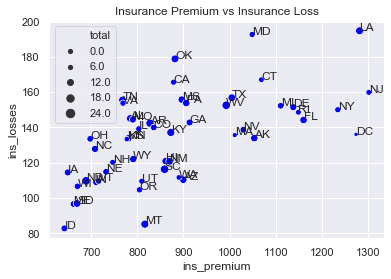

In [27]:
x = df_car_crashes.iloc[:,5] #premium
y = df_car_crashes.iloc[:,6] #loss
total = df_car_crashes.iloc[:,0]
labels = stateSeries

sns.set()
scatterplot = sns.scatterplot(x='ins_premium',y='ins_losses',size=total,data=df_car_crashes,color='blue')
for line in range(0,df_car_crashes.shape[0]):
    scatterplot.text(x[line],y[line],stateSeries[line])
    
plt.title('Insurance Premium vs Insurance Loss')
scatterplot

### 26) [P] Next, generate two interesting plots that show some relationships between variables in the data. Try to use as many variables as you can without creating chaos! Don't just throw in multiple variables for the sake of showing them, only include them if it makes sense to do so. Your aim is to derive meaning from your data. Good visualizations tell a story. Strive to use at least one additional variable as size, color, or shape in your data, so you can show more than just 2 variables on a single plot. Add titles, legends and label your axes as appropriate. After each plot, create a markdown cell and briefly draw conclusions from your plot.

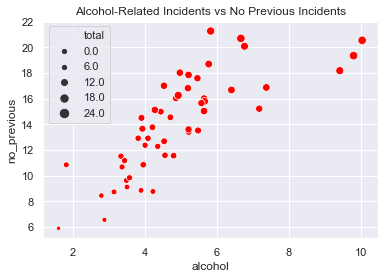

In [28]:
total = df_car_crashes.iloc[:,0]
labels = stateSeries

scatterplot = sns.scatterplot(x='alcohol',y='no_previous',size=total,data=df_car_crashes,color='red')
    
plt.title('Alcohol-Related Incidents vs No Previous Incidents')
scatterplot

Looking at this plot, we can see a fairly strong positive correlation that happens between number of no_previous incidents, as well as alcohol related incidents when looking at car crash data for states. It looks as if there could be a linear pattern present between the number of first-time crashes a state has, and the amount of car crashes involving alcohol a state has

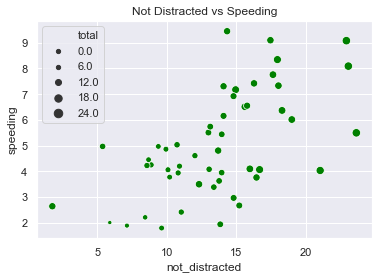

In [29]:
total = df_car_crashes.iloc[:,0]
labels = stateSeries

scatterplot = sns.scatterplot(x='not_distracted',y='speeding',size=total,data=df_car_crashes,color='green')
    
plt.title('Not Distracted vs Speeding')
scatterplot

For this plot, we can see that there may be a slight correlation between the speeding variable and the not_distracted variable. This may suggest a pattern is present between how many speeding crashes occur, and how many non-distracted crashes occur.

### 27) [P] Run a full PCA on the z_score transformed data. Set n_components to be the same number of columns as the data. Be sure to fit the data to your PCA model, and then output the components, explained variance, and the explained variance ratio.

In [30]:
PCA_z_score = PCA(n_components=df_car_crashes_zscore.shape[1])
PCA_z_score.fit(df_car_crashes_zscore)
display(pd.DataFrame(PCA_z_score.components_))
display(pd.DataFrame(PCA_z_score.explained_variance_))
display(pd.DataFrame(PCA_z_score.explained_variance_ratio_))

0         1         2         3         4         5         6
0  0.479471  0.375347  0.454376  0.438033  0.457034 -0.130832 -0.069960
1  0.068938  0.076585  0.033458  0.042375  0.096129  0.685227  0.712524
2 -0.269088  0.818269  0.082933 -0.126168 -0.317988  0.256142 -0.261735
3  0.038956 -0.363749  0.148344  0.171266  0.039481  0.656396 -0.618399
4  0.145977 -0.022828  0.354798 -0.856469  0.336110  0.042145 -0.063272
5 -0.169705 -0.224792  0.783768  0.085105 -0.504012 -0.115773  0.178052
6  0.800825  0.017848 -0.152858 -0.142478 -0.558754  0.041266 -0.028050

0
0  4.094231
1  1.609573
2  0.561614
3  0.357540
4  0.286385
5  0.202633
6  0.028024

0
0  0.573422
1  0.225430
2  0.078657
3  0.050076
4  0.040110
5  0.028380
6  0.003925

### 28) [M] Use your intuition – what do the weights of the first couple of components suggest explains most of the variance in the data?

Looking at the first two indices of z_score for variance and variance ratio, we see that the scores are unusually higher than compared to the rest of the entries. We believe that this may be cause by an increased presence of outlier data values present within these specific indices.

### 29) [P] Create a plot of the cumulative sum of the explained variance. How many components will get you to 90% of the explained variance?

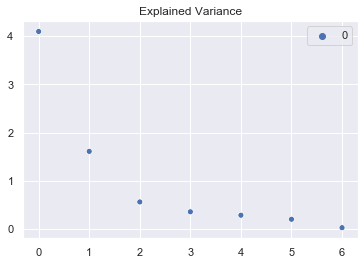

In [31]:
exp_var = pd.DataFrame(PCA_z_score.explained_variance_)

scatterplot = sns.scatterplot(data=exp_var,color='green')
    
plt.title('Explained Variance')
scatterplot

#

### 30) [P] Transform the z_score transformed data using your PCA model (i.e. using the transform function of the pca object.)

In [32]:
pca_z_score_transformed = PCA_z_score.transform(df_car_crashes_zscore)
pca_z_score_transformed = pd.DataFrame(pca_z_score_transformed)
display(pca_z_score_transformed)

0         1         2         3         4         5         6
0   1.603671  0.133449  0.317881 -0.795293 -0.579719  0.046223  0.210185
1   1.144212  0.858234  0.736626  0.318988 -0.228701 -1.002625  0.008966
2   1.432172 -0.420506  0.338136  0.552513  0.168718 -0.804523 -0.076107
3   2.491584  0.348968 -1.788747  0.264064 -0.372382 -0.481849 -0.147636
4  -1.750638  0.633625 -0.136176 -0.974916 -0.315811  0.178510 -0.068958
5  -0.925120 -0.154388  0.146177 -0.568096  0.116420 -0.240859 -0.098428
6  -2.125359  1.370600  0.743078 -0.485553 -0.088337  0.486531  0.020256
7   0.324658  1.574245  0.440982  0.338057  0.095481 -0.466100 -0.188961
8  -4.635926  0.918997  0.720078  1.184313 -0.172554 -0.052800 -0.124806
9   0.495689  1.435282 -0.661126  1.185136 -0.108007 -0.244305 -0.086714
10 -0.525427  0.266688 -0.996973  0.224700 -0.396993 -0.216235 -0.085949
11  1.928047 -0.210245  1.802469 -0.307749  0.474235  0.243974 -0.027264
12  0.313123 -2.427597  0.346267  0.242471  0.156261 -0.601429 -0.179853
13 -0.879340 -0.325337  0.030223 -0.510003 -0.104465  0.214890 -0.260829
14 -0.395326 -1.517806 -0.480372  0.170787 -0.207524 -0.138441 -0.188620
15 -0.350122 -1.606357 -1.143953  0.018727 -0.530035 -0.085099  0.013598
16  0.268724 -0.388644 -0.487894 -0.360658 -0.000996 -0.428149  0.250526
17  1.079427  0.167894 -1.079836  0.249861 -0.186248 -0.329688  0.644697
18  1.879427  3.648218  0.044439 -0.119691  0.753572 -0.199459 -0.157203
19  0.033165 -2.000912  0.533298 -0.086128 -0.098662 -0.174564  0.105598
20 -1.708747  2.126422 -0.245391 -1.031566  0.350294  0.261180 -0.207411
21 -3.651457 -0.025082  0.113215  0.426712 -0.063149  0.553208  0.012150
22 -1.370703  1.191239 -0.186198  0.541027 -0.478532  0.226347  0.247314
23 -2.909039 -0.903774 -0.364751 -0.368156 -0.166400  0.326086 -0.079624
24 -0.864891  0.583746 -1.243684 -0.420313  2.747442 -0.112549  0.099181
25  0.659733  0.003254  0.556189 -0.863878 -0.218926  0.263466  0.024157
26  3.627923 -1.242992  1.161788  1.027460  0.743786  0.670637 -0.001845
27 -0.467083 -1.309009 -1.151495  0.501488 -0.023241  0.576539 -0.164922
28 -0.106028  0.689652  0.348203  0.339661 -0.084383 -0.217774 -0.259724
29 -1.775362 -1.239018  0.243905 -0.333879 -0.154285  0.149904  0.045691
30 -3.018309  1.935870 -0.202882  1.084987 -0.175650  0.299146  0.210557
31  0.469291 -0.384486 -0.970288  0.582329  0.760605 -0.558852 -0.060830
32 -2.041784  1.538860  0.502944  0.797447 -0.191340  0.055756  0.199052
33  0.816262 -0.793312  0.368251 -0.661200 -0.402007  0.095075  0.137858
34  4.423619 -0.965716 -0.948543  0.775273  0.023569  1.222200 -0.185898
35 -0.539149 -0.892627 -0.389892 -0.523138 -0.404637  0.600677 -0.021991
36  1.893587  1.569755 -0.682062 -1.038087 -0.285300 -0.140813 -0.167974
37 -1.559410 -1.407253  0.356474  0.205008  0.370710 -0.423845  0.092349
38  1.814053  0.936589  1.097425 -0.903765 -0.416062 -0.285857 -0.001473
39 -2.164484  1.119077  0.547331  0.555804 -0.093357  0.600640  0.065785
40  4.672014 -0.019524  0.807443  0.529369 -0.013393  0.793271  0.101770
41  2.147476 -1.684670 -0.046152  0.354682 -0.325454  0.041000 -0.001036
42  0.954879  0.260777 -1.195367 -0.594569 -0.082671  0.333748  0.253928
43  2.204308  1.432642  0.586286 -0.189818  0.059423  0.450637 -0.047766
44 -1.985211 -1.283064  0.615428 -0.116365 -0.339627 -0.979614 -0.007981
45 -0.630338 -1.504611 -0.146494  0.035877 -0.210385 -0.106305 -0.198325
46 -1.797349 -0.177639 -0.988900 -0.734181 -0.231569  0.303000 -0.044200
47 -2.096452 -0.958969  0.854118  0.277163  0.087962  0.041864  0.016137
48  3.619129  1.485286 -0.054355  0.041551 -0.622525 -0.530780  0.136625
49 -1.187447 -1.829767  0.522376 -0.486705  1.234004  0.044176  0.243181
50  1.164326 -0.556064  0.710502 -0.351745  0.230845 -0.256171  0.002769

### 31) [P] Generate a 2D plot using the first two principal components as your x and y coordinates. Be sure to label each point, and label your axes as component 1 and component 2, respectively.

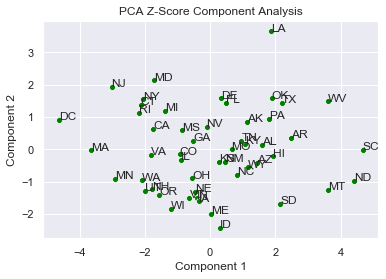

In [33]:
x = pca_z_score_transformed.iloc[:,0]
y = pca_z_score_transformed.iloc[:,1]

labels = stateSeries

scatterplot = sns.scatterplot(x=0,y=1,data = pca_z_score_transformed,color='green')
for line in range(0,pca_z_score_transformed.shape[0]):
    scatterplot.text(x[line],y[line],stateSeries[line])
    
plt.title('PCA Z-Score Component Analysis')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
scatterplot

### 32) [M] Compare the states you reported as potential outliers above to those that appear to be outliers from your plot. Do the same results seem to hold?

Looking at the graph, we do still see that areas such as DC, SC, ND, MT, and LA are vast outliers when compared with the other observations. This supports what we said above in question(s) 23/24, so our results do still seem to hold.

### 33) [P] Read how to generate a 3D scatterplot in seaborn or plotly, and use it to generate a scatterplot of the first 3 components.

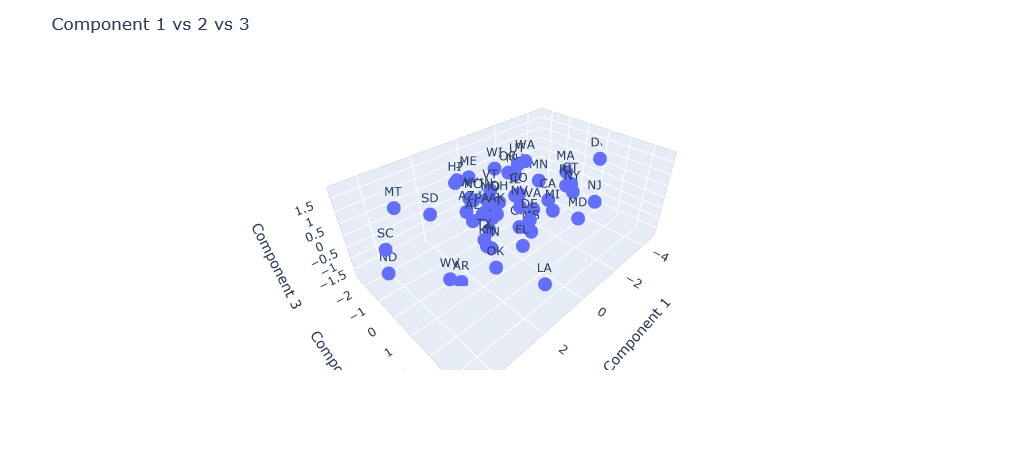

In [35]:
import plotly.express as px
import plotly.graph_objects as go

x = pca_z_score_transformed.iloc[:,0]
y = pca_z_score_transformed.iloc[:,1]
z = pca_z_score_transformed.iloc[:,2]


fig = px.scatter_3d(
x=x, y = y, z = z ,text=df_car_crashes_zscore.index, labels={'x':'Component 1', 'y':'Component 2', 'z': 'Component 3'})


fig.update_layout(
title="Component 1 vs 2 vs 3",
)

fig.show()

### 34) [M] Do the same outliers still stand out?

Yes, we still see points from DC, SC, ND, MT, and LA at larger variance points compared to other states.